In [1]:
import ECGDataset 
import Models 
import Net
from train_test_validat import *
from self_attention import *
import matplotlib.pyplot as plt
import ecg_plot
import cam
import ECGplot
import ECGHandle
import torch
import torch.utils.data as Data
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
import random
import pandas as pd
from tqdm import tqdm

import time
import math
import os
import gc
from torch.utils.tensorboard import SummaryWriter


def seed_torch(seed=2023):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False 
    torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.enabled = False

In [2]:
EcgChannles_num = 12
EcgLength_num = 5000
DEVICE = cpu
# DEVICE = torch.device(\cuda:0\ if torch.cuda.is_available() else \cpu\)    
seed_torch(2023)

In [25]:
data_root = '/workspace/data/Preprocess_HTN/datas_/'    
ALL_data = pd.read_csv(data_root+'/All_data_handled_ID_range_age_IDimputate.csv',low_memory=False)    
ALL_data = ECGHandle.change_label(ALL_data)    
ALL_data = ECGHandle.filter_ID(ALL_data)    
ALL_data = ECGHandle.filter_QC(ALL_data)    
ALL_data = ECGHandle.filter_ages(ALL_data,18)    
ALL_data = ECGHandle.filter_departmentORlabel(ALL_data,'外科')    
ALL_data = ECGHandle.correct_label(ALL_data)    
ALL_data = ECGHandle.correct_age(ALL_data)    
ALL_data = ECGHandle.filter_diagnose(ALL_data,'起搏')    
ALL_data = ECGHandle.filter_diagnose(ALL_data,'房颤')    
# ALL_data = ECGHandle.filter_diagnose(ALL_data,'左束支传导阻滞')    
# ALL_data = ECGHandle.filter_diagnose(ALL_data,'左前分支阻滞')    
# ALL_data = ECGHandle.filter_diagnose(ALL_data,'阻滞')    
# ALL_data = ECGHandle.remove_duplicated(ALL_data)    
ALL_data = ALL_data.rename(columns={'住院号':'ID','年龄':'age','性别':'gender','姓名':'name'})     
ALL_data_buffer = ALL_data.copy()    
seed_torch(2023)    
ALL_data_buffer = ALL_data_buffer.sample(frac=1).reset_index(drop=True) #打乱顺序    
# all_dataset = ECGHandle.ECG_Dataset(data_root,ALL_data_buffer,preprocess = True)    
####################################################################随机选取test    
test_df,tv_df = Pair_ID(ALL_data,0.2,Range_max=15,pair_num=1)    
test_dataset = ECGHandle.ECG_Dataset(data_root,test_df,preprocess = True)    



            orginal   removed diagnose NaN
   nums      200082          199997       
              HTN             NHTN        
   nums       3273           196724       


            orginal      removed ID NaN   
   nums      199997          199995       
              HTN             NHTN        
   nums       3273           196722       


            orginal            QC         
   nums      199995          72845        
              HTN             NHTN        
   nums       1497           71348        


            orginal      filtered ages    
   nums      72845           69819        
              HTN             NHTN        
   nums       1477           68342        


            orginal   filtered department 
   nums      69819           15344        
              HTN             NHTN        
   nums       1477           13867        


     reset num:       10  
  ERR labels num:     27  
            orginal      correct label    
   nums      15344           15

In [41]:
def Find_Optimal_Cutoff(TPR, FPR, threshold):
    y = TPR - FPR
    Youden_index = np.argmax(y)  # Only the first occurrence is returned.
    optimal_threshold = threshold[Youden_index]
    point = [FPR[Youden_index], TPR[Youden_index]]
    return optimal_threshold, point
def ROC(label, y_prob):
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(label, y_prob)
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    optimal_th, optimal_point = Find_Optimal_Cutoff(TPR=tpr, FPR=fpr, threshold=thresholds)
    return fpr, tpr, roc_auc, optimal_th, optimal_point
def get_best_auc(y_true,y_out):
    fpr, tpr, roc_auc, optimal_th, optimal_point = ROC(y_true,((np.array(y_out))[:,1]))
    plt.figure(1)
    plt.plot(fpr, tpr, label= f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.plot(optimal_point[0], optimal_point[1], marker='o', color='r')
    plt.text(optimal_point[0], optimal_point[1], f'Threshold:{optimal_th:.2f}')
    plt.title("ROC-AUC")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    y_pred = ((np.array(y_out))[:,1])
    y_pred[y_pred>optimal_th] =  int(1)
    y_pred[y_pred<=optimal_th] =  int(0)
    CM = confusion_matrix(y_true,y_pred)

    F1_score =f1_score(y_true, y_pred, average='binary')#F1分数
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')   
    print('\n',CM[0],'\n',CM[1],'\n',"precision: ",precision,"recall: ",recall,'AUC',roc_auc,'F1',F1_score)
    return y_pred

fold  0  :
  BestF1  



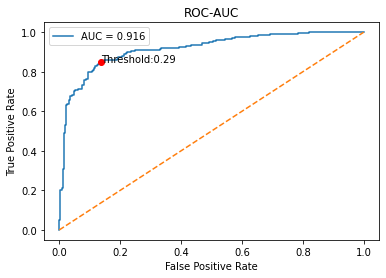

[[228  36]
 [ 42 232]]

 [228  36] 
 [ 42 232] 
 precision:  0.8656716417910447 recall:  0.8467153284671532 AUC 0.916113691661137 F1 0.8560885608856089
  BestLoss  



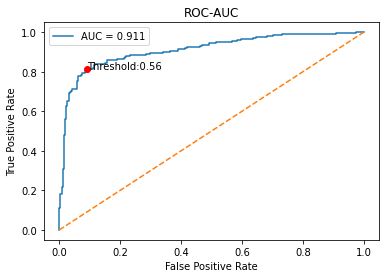

[[240  24]
 [ 53 221]]

 [240  24] 
 [ 53 221] 
 precision:  0.9020408163265307 recall:  0.8065693430656934 AUC 0.9106392391063922 F1 0.8516377649325626
fold  1  :
  BestF1  



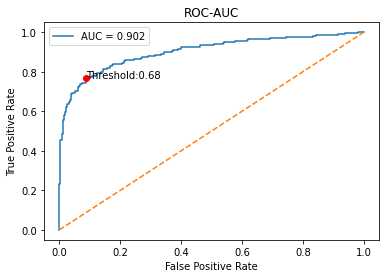

[[241  23]
 [ 65 209]]

 [241  23] 
 [ 65 209] 
 precision:  0.9008620689655172 recall:  0.7627737226277372 AUC 0.9022340190223402 F1 0.8260869565217391
  BestLoss  



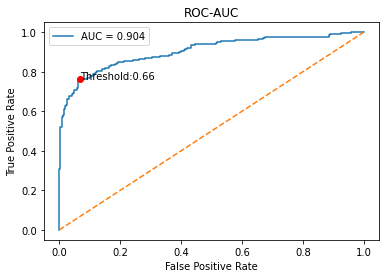

[[246  18]
 [ 66 208]]

 [246  18] 
 [ 66 208] 
 precision:  0.9203539823008849 recall:  0.7591240875912408 AUC 0.9042662021676621 F1 0.832
fold  2  :
  BestF1  



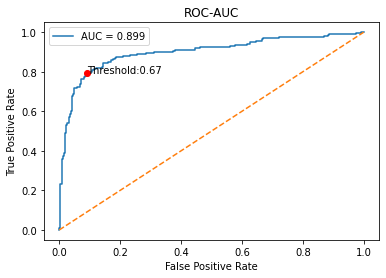

[[240  24]
 [ 58 216]]

 [240  24] 
 [ 58 216] 
 precision:  0.9 recall:  0.7883211678832117 AUC 0.8986396814863968 F1 0.8404669260700389
  BestLoss  



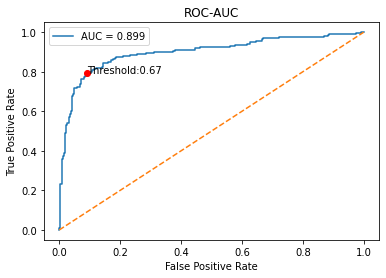

[[240  24]
 [ 58 216]]

 [240  24] 
 [ 58 216] 
 precision:  0.9 recall:  0.7883211678832117 AUC 0.8986396814863968 F1 0.8404669260700389
fold  3  :
  BestF1  



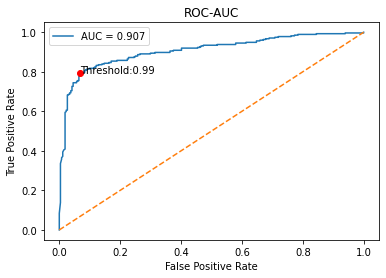

[[246  18]
 [ 59 215]]

 [246  18] 
 [ 59 215] 
 precision:  0.9227467811158798 recall:  0.7846715328467153 AUC 0.9069757796947577 F1 0.8481262327416174
  BestLoss  



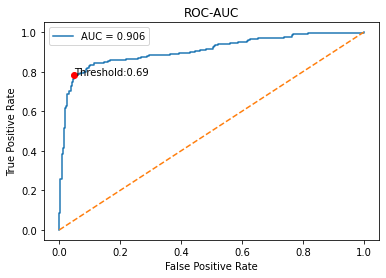

[[251  13]
 [ 60 214]]

 [251  13] 
 [ 60 214] 
 precision:  0.9427312775330396 recall:  0.781021897810219 AUC 0.9062154390621544 F1 0.8542914171656687
fold  4  :
  BestF1  



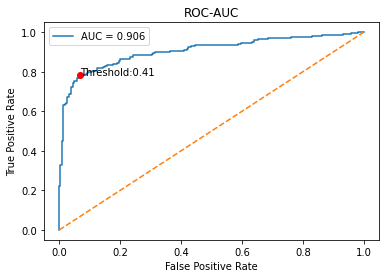

[[246  18]
 [ 60 214]]

 [246  18] 
 [ 60 214] 
 precision:  0.9224137931034483 recall:  0.781021897810219 AUC 0.9059804246848042 F1 0.8458498023715415
  BestLoss  



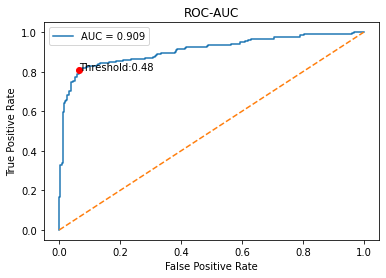

[[247  17]
 [ 54 220]]

 [247  17] 
 [ 54 220] 
 precision:  0.9282700421940928 recall:  0.8029197080291971 AUC 0.9087729484627295 F1 0.8610567514677104


: 

In [49]:
Models_path = '/workspace/data/Interpretable_HTN/model/20230315_151049/20230315_151049/BestF1_1.pt'
for i in range(5):
    print('fold ',i,' :')
    Models_path = '/workspace/data/Interpretable_HTN/model/20230315_151049/20230315_151049/BestF1_'+str(i)+'.pt'
    NET = [Net.MLBFNet_GUR_o(True,True,True,2,Dropout_rate=0.3), ] # type: ignore
    criterion = torch.nn.CrossEntropyLoss()
    testmodel = NET[0].to(DEVICE)
    testmodel.load_state_dict(torch.load(Models_path))
    test_dataloader = Data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)  
    y_true,y_pred,y_out,test_loss,test_acc = eval_model(test_dataloader,criterion,testmodel,DEVICE) # 验证模型"
    print('  BestF1 ','\n')
    _ = get_best_auc(y_true,y_out)
    
    Models_path = '/workspace/data/Interpretable_HTN/model/20230315_151049/20230315_151049/parameter_EarlyStoping_'+str(i)+'.pt'
    NET = [Net.MLBFNet_GUR_o(True,True,True,2,Dropout_rate=0.3), ] # type: ignore
    criterion = torch.nn.CrossEntropyLoss()
    testmodel = NET[0].to(DEVICE)
    testmodel.load_state_dict(torch.load(Models_path))
    test_dataloader = Data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)  
    y_true,y_pred,y_out,test_loss,test_acc = eval_model(test_dataloader,criterion,testmodel,DEVICE) # 验证模型"
    print('  BestLoss ','\n')
    _ = get_best_auc(y_true,y_out)